# Tutorial 03b: From Failure to Success — The Power of Priors

In Tutorial 03, we saw that standard deep RL (e.g., PPO) with large neural networks
can struggle to outperform simple baselines on EV charging. In this sequel, we
show how to leverage domain priors to achieve stronger performance with a fraction
of the parameters — and better robustness.

**Key idea:** encode structure (what to do), learn only a few critical thresholds (how much).
We compare against the Greedy baseline used in Tutorial 02.

In [13]:
# Standard setup and imports
import sys
from pathlib import Path

try:
    nb_dir = Path(__file__).parent
except NameError:
    nb_dir = Path.cwd()

repo_root = nb_dir.parent  # tutorials/ -> repo root
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, Dict, Any, Optional, Tuple, List

# Tutorial utilities (single import hub)
from tutorials.utils import (
    # Notebook helpers
    show, show_metrics, quick_plot,
    # Env factory and planning config
    create_ev_env, PlanningEvalConfig, get_planning_eval_env_fn, apply_wrappers,
    # Baselines and wrappers
    GreedyAlgorithm, wrap_policy,
    DepartureUncertaintyWrapper, GrowingForecastErrorWrapper, CarbonEmphasisWrapper, DemandChargeWrapper,
    # Eval helpers
    evaluate_policy, rollout_to_trajectory,
    # Shapes
    get_obs_shape, get_action_dim,
    # Vector envs
    make_vec_envs,
)

# Device selection (CUDA/MPS/CPU)
if torch.cuda.is_available():
    device = torch.device("cuda")
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
show("metric: Using device: {device}", device=device)

## 1. Standardized Evaluation Environment

We reuse the planning-friendly evaluation settings introduced in Tutorials 02/03
to keep comparisons consistent. We construct a single evaluation environment with
dict observations (used by our simple/prior policies). For robustness sweeps, we
expose `noise` and `noise_action` at construction.

Notation note: throughout this tutorial, actions are normalized charging rates
$\boldsymbol{\rho}^{\text{rate}}\in[0,1]^N$ (often called the "pilot"). Hardware maps
these to currents via the per‑station maximum $I^{\text{max}}=32\,\text{A}$.

In [14]:
EVAL_CFG = PlanningEvalConfig(
    density_multiplier=3.0,
    violation_weight=0.05,
    carbon_multiplier=0.3,
    departure_extension_steps=24,
    enable_forecast_error=True,
    enable_demand_charge=False,
    demand_charge_per_kw=200.0,
    seed=42,
)

# Build a planning-friendly env using the same structure as get_planning_eval_env_fn,
# but allowing us to pass noise and flatten as needed.

def make_eval_env(*, flatten: bool = False, noise: float = 0.0, noise_action: float = 0.0):
    base = create_ev_env(
        site='caltech',
        date_range=('2019-05-01', '2019-08-31'),
        seed=EVAL_CFG.seed,
        flatten=flatten,
        moer_forecast_steps=36,
        project_action_in_env=False,
        dense_mode=True,
        density_multiplier=EVAL_CFG.density_multiplier,
        violation_weight=EVAL_CFG.violation_weight,
        noise=noise,
        noise_action=noise_action,
    )
    wrappers = [
        (CarbonEmphasisWrapper, {'multiplier': EVAL_CFG.carbon_multiplier}),
        (DepartureUncertaintyWrapper, {
            'uncertainty_mode': 'optimistic_bias',
            'params': {'avg_extension_steps': int(EVAL_CFG.departure_extension_steps)},
            'rng_seed': int(EVAL_CFG.seed) + 1,
        }),
    ]
    if EVAL_CFG.enable_forecast_error:
        wrappers.append((GrowingForecastErrorWrapper, {
            'error_model': 'linear_growth',
            'params': {'linear_scale': 0.0075},
            'rng_seed': int(EVAL_CFG.seed) + 2,
        }))
    if EVAL_CFG.enable_demand_charge:
        wrappers.append((DemandChargeWrapper, {
            'charge_per_kw': float(EVAL_CFG.demand_charge_per_kw),
            'window_minutes': 15,
            'expose_peak_in_obs': False,
        }))
    return apply_wrappers(base, wrappers)

# Factories
make_env_dict = lambda: make_eval_env(flatten=False)

show("section: Evaluation Environment Settings")
show_metrics({
    'Density multiplier': EVAL_CFG.density_multiplier,
    'Violation weight': EVAL_CFG.violation_weight,
    'Carbon multiplier': EVAL_CFG.carbon_multiplier,
    'Departure ext (steps)': EVAL_CFG.departure_extension_steps,
    'Forecast error enabled': EVAL_CFG.enable_forecast_error,
    'Demand charge enabled': EVAL_CFG.enable_demand_charge,
}, title='Standardized Evaluation Settings')

## 2. Policies Under Test

We compare:
- Greedy baseline (0 learned params)
- Learnable Greedy (4 params)
- Shared Linear Policy (4 shared params across stations)
- Memory-Augmented Greedy (5 params + 1 state)

All prior-based policies operate on dict observations for clarity.

In [15]:
# Helper: extract signals safely from dict observations

def _extract_demands(obs: Any) -> np.ndarray:
    if isinstance(obs, dict) and ('demands' in obs):
        return np.asarray(obs['demands'], dtype=float).reshape(-1)
    return np.zeros(1, dtype=float)

def _extract_moer(obs: Any) -> float:
    # Prefer previous (current) MOER if exposed
    if isinstance(obs, dict):
        try:
            if 'prev_moer' in obs and len(obs['prev_moer']) > 0:
                return float(np.asarray(obs['prev_moer'])[0])
            # Fallback: first forecast step
            if 'forecasted_moer' in obs and len(obs['forecasted_moer']) > 0:
                return float(np.asarray(obs['forecasted_moer'])[0])
        except Exception:
            pass
    return 0.5

def _features_from_obs(obs: Any) -> Tuple[torch.Tensor, torch.Tensor]:
    """Return (station_features, base_mask) for one dict observation.
    station_features: [n_stations, 3] = [active, demand, moer]
    base_mask: [n_stations] in [0,1]
    """
    d = _extract_demands(obs)
    m = _extract_moer(obs)
    active = (d > 0).astype(float)
    feats = np.stack([active, d, np.full_like(d, m)], axis=-1).astype(np.float32)
    # Default thresholds (actor has learnable ones and will override effectively)
    dt, mt, cr, ub = 0.1, 0.5, 0.7, 2.0
    has_demand = 1.0 / (1.0 + np.exp(-(d - dt) * 10.0))
    low_carbon = 1.0 / (1.0 + np.exp(-((mt - m) * 10.0)))
    urgency = 1.0 / (1.0 + np.exp(-(ub * d)))
    base = np.clip(has_demand * low_carbon * (cr * urgency), 0.0, 1.0).astype(np.float32)
    return torch.from_numpy(feats), torch.from_numpy(base)

# --- Prior-based minimal policies (few parameters) ---

@dataclass
class LearnableGreedy:
    demand_threshold: float = 0.1
    moer_threshold: float = 0.5
    charge_rate: float = 0.7
    urgency_boost: float = 2.0

    def get_action(self, obs: Any) -> np.ndarray:
        d = _extract_demands(obs)
        m = _extract_moer(obs)
        has_demand = 1.0 / (1.0 + np.exp(-(d - self.demand_threshold) * 10.0))
        low_carbon = 1.0 / (1.0 + np.exp(-((self.moer_threshold - m) * 10.0)))
        urgency = 1.0 / (1.0 + np.exp(-(self.urgency_boost * d)))
        action = has_demand * low_carbon * (self.charge_rate * urgency)
        return np.clip(action, 0.0, 1.0)

    def describe(self) -> Dict[str, float]:
        return {
            'demand_threshold': self.demand_threshold,
            'moer_threshold': self.moer_threshold,
            'charge_rate': self.charge_rate,
            'urgency_boost': self.urgency_boost,
        }

    def parameter_count(self) -> int:
        return 4

@dataclass
class SharedLinearPolicy:
    # Shared linear model per station: sigmoid(w0 + w1*active + w2*demand + w3*moer)
    w0: float = -1.0
    w1: float = 1.0
    w2: float = 2.0
    w3: float = -1.0

    def get_action(self, obs: Any) -> np.ndarray:
        d = _extract_demands(obs)
        m = _extract_moer(obs)
        active = (d > 0).astype(float)
        z = self.w0 + self.w1 * active + self.w2 * d + self.w3 * m
        action = 1.0 / (1.0 + np.exp(-z))
        return np.clip(action, 0.0, 1.0)

    def describe(self) -> Dict[str, float]:
        return {'w0': self.w0, 'w1': self.w1, 'w2': self.w2, 'w3': self.w3}

    def parameter_count(self) -> int:
        return 4

@dataclass
class MemoryAugmentedGreedy:
    demand_threshold: float = 0.1
    moer_base_threshold: float = 0.5
    memory_weight: float = 0.3    # EMA weight
    trend_sensitivity: float = 1.0
    charge_rate: float = 0.8

    # Internal state (not a parameter)
    moer_ema: float = 0.5

    def reset_memory(self):
        self.moer_ema = 0.5

    def get_action(self, obs: Any) -> np.ndarray:
        d = _extract_demands(obs)
        m = _extract_moer(obs)
        # Update EMA of MOER
        self.moer_ema = float(self.memory_weight * m + (1.0 - self.memory_weight) * self.moer_ema)
        moer_trend = m - self.moer_ema
        adaptive_thr = self.moer_base_threshold - self.trend_sensitivity * moer_trend
        has_demand = 1.0 / (1.0 + np.exp(-(d - self.demand_threshold) * 10.0))
        low_carbon = 1.0 / (1.0 + np.exp(-((adaptive_thr - m) * 10.0)))
        action = has_demand * low_carbon * self.charge_rate
        return np.clip(action, 0.0, 1.0)

    def describe(self) -> Dict[str, float]:
        return {
            'demand_threshold': self.demand_threshold,
            'moer_base_threshold': self.moer_base_threshold,
            'memory_weight': self.memory_weight,
            'trend_sensitivity': self.trend_sensitivity,
            'charge_rate': self.charge_rate,
        }

    def parameter_count(self) -> int:
        return 5

## 3. Simple Random Local Search for Parameter Optimization

We use random local search (hill climbing) to optimize the few learnable parameters of our prior-based policies—a robust gradient-free method well-suited for small parameter spaces.

### Algorithm Description

Given policy parameters $\boldsymbol{\theta} \in \mathbb{R}^d$ where $d \in \{4, 5\}$, we maintain a center point $\boldsymbol{\theta}_{\text{best}}$ initialized from domain knowledge.

**Candidate Generation:** At iteration $t$, sample $K = 8$ candidates:
$$\boldsymbol{\theta}^{(k)} = \boldsymbol{\theta}_{\text{best}} + \boldsymbol{\epsilon}^{(k)}, \quad \boldsymbol{\epsilon}^{(k)} \sim \mathcal{N}(0, \sigma^2 \mathbf{I})$$
where $\sigma = 0.075$ controls exploration.

**Evaluation:** Each candidate is evaluated over $E = 3$ episodes ($H = 288$ steps) using:
$$J(\boldsymbol{\theta}) = R(\boldsymbol{\theta}) - \alpha \cdot C(\boldsymbol{\theta})$$
where $R(\boldsymbol{\theta})$ = mean return, $C(\boldsymbol{\theta})$ = mean safety cost, $\alpha = 0.7$.

**Update Rule:** Winner-take-all strategy:
$$\boldsymbol{\theta}_{\text{best}} \leftarrow \begin{cases}
\arg\max_{\boldsymbol{\theta}^{(k)}} J(\boldsymbol{\theta}^{(k)}) & \text{if } \max_k J(\boldsymbol{\theta}^{(k)}) > J(\boldsymbol{\theta}_{\text{best}}) \\
\boldsymbol{\theta}_{\text{best}} & \text{otherwise}
\end{cases}$$

**Parameter Bounds:** 
- Demand threshold: $[-0.5, 1.5]$
- MOER threshold: $[0.0, 2.0]$  
- Charge rate: $[0.0, 1.5]$
- Urgency boost: $[0.0, 5.0]$

### Efficiency

Unlike [Augmented Random Search (ARS)](https://papers.nips.cc/paper_files/paper/2018/hash/7634ea65a4e6d9041cfd3f7de18e334a-Abstract.html) which uses finite differences and weighted averaging, or [Evolutionary Search methods as applied in the winning solution to the 2021 CityLearn Challenge](https://ojs.aaai.org/index.php/AAAI/article/view/26671/26443), our simpler approach is more sample-efficient for small parameter spaces. The algorithm typically uses orders of magnitude fewer than standard deep RL methods require for similar domains.

In [16]:
@dataclass
class TuneConfig:
    iterations: int = 40
    candidates_per_iter: int = 8
    episodes: int = 2
    horizon: int = 288
    noise_scale: float = 0.1
    seed: int = 123

rng_global = np.random.default_rng(123)


def _sample_params(center: Dict[str, float], noise_scale: float) -> Dict[str, float]:
    out = {}
    for k, v in center.items():
        out[k] = float(v + rng_global.normal(0.0, noise_scale))
    return out


def _assign_params(policy_obj: Any, params: Dict[str, float]) -> None:
    for k, v in params.items():
        if hasattr(policy_obj, k):
            setattr(policy_obj, k, float(v))


def _clip_params(params: Dict[str, float]) -> Dict[str, float]:
    """Clamp parameter proposals to reasonable bounds to keep tuning stable.
    Bounds chosen to allow greedy-like behavior but prevent extreme values.
    """
    bounds = {
        # LearnableGreedy
        'demand_threshold': (-0.5, 1.5),
        'moer_threshold': (0.0, 2.0),
        'charge_rate': (0.0, 1.5),
        'urgency_boost': (0.0, 5.0),
        # SharedLinearPolicy
        'w0': (-5.0, 5.0),
        'w1': (-5.0, 5.0),
        'w2': (-5.0, 5.0),
        'w3': (-5.0, 5.0),
        # MemoryAugmentedGreedy
        'moer_base_threshold': (0.0, 2.0),
        'memory_weight': (0.0, 1.0),
        'trend_sensitivity': (0.0, 5.0),
    }
    clipped = {}
    for k, v in params.items():
        if k in bounds:
            lo, hi = bounds[k]
            clipped[k] = float(np.clip(v, lo, hi))
        else:
            clipped[k] = float(v)
    return clipped


def tune_policy(
    policy_obj: Any,
    make_env_fn: Callable[[], Any],
    cfg: TuneConfig,
    alpha: float = 0.7,
    milestones: Optional[List[int]] = None,
) -> Tuple[Any, pd.DataFrame]:
    rng = np.random.default_rng(cfg.seed)
    history: List[Dict[str, Any]] = []

    # Center at current params
    center = dict(policy_obj.describe()) if hasattr(policy_obj, 'describe') else {}
    best_params = dict(center)

    # Evaluate current
    def _evaluate_current(obj):
        # Ensure any internal memory/state is reset for fair, comparable trials
        try:
            if hasattr(obj, 'reset_memory') and callable(getattr(obj, 'reset_memory')):
                obj.reset_memory()  # type: ignore
        except Exception:
            pass
        mean_ret, std_ret, mean_cost, _m = evaluate_policy(
            policy_fn=obj.get_action, make_env_fn=make_env_fn,
            episodes=cfg.episodes, horizon=cfg.horizon,
            track_metrics=['satisfaction', 'components', 'actions'], verbose=False)
        return mean_ret, mean_cost

    best_score_ret, best_score_cost = _evaluate_current(policy_obj)
    if milestones is None:
        # Default sparse milestones over iterations
        q1 = max(1, cfg.iterations // 4)
        q2 = max(1, cfg.iterations // 2)
        milestones = [1, q1, q2, cfg.iterations]

    for it in range(cfg.iterations):
        candidates: List[Tuple[Dict[str, float], float, float]] = []
        for _ in range(cfg.candidates_per_iter):
            trial = _sample_params(best_params, cfg.noise_scale)
            _assign_params(policy_obj, trial)
            # Reset internal memory/state before each candidate evaluation
            try:
                if hasattr(policy_obj, 'reset_memory') and callable(getattr(policy_obj, 'reset_memory')):
                    policy_obj.reset_memory()  # type: ignore
            except Exception:
                pass
            mean_ret, mean_cost = _evaluate_current(policy_obj)
            candidates.append((trial, mean_ret, mean_cost))
        # Select best by composite score: mean_return - alpha * mean_cost
        best = max(candidates, key=lambda t: (t[1] - float(alpha) * t[2]))
        trial_params, trial_ret, trial_cost = best
        # Update if composite improves
        if (trial_ret - float(alpha) * trial_cost) > (best_score_ret - float(alpha) * best_score_cost):
            best_params = trial_params
            best_score_ret, best_score_cost = trial_ret, trial_cost
        # Log
        iter_idx = it + 1
        row = {
            'iter': iter_idx,
            'best_return': best_score_ret,
            'best_cost': best_score_cost,
            'best_composite': float(best_score_ret - float(alpha) * best_score_cost),
            'is_milestone': bool(iter_idx in milestones),
            **{f'p_{k}': v for k, v in best_params.items()}
        }
        history.append(row)
        if row['is_milestone']:
            try:
                show(
                    "metric: Tuning milestone {it}: composite={comp:.3f}, return={ret:.3f}, cost={cost:.3f}",
                    it=iter_idx, comp=row['best_composite'], ret=row['best_return'], cost=row['best_cost']
                )
            except Exception:
                pass
        if (it % 5) == 0:
            # Re-center occasionally
            best_params = _clip_params(best_params)
            center = dict(best_params)
    # Assign final best params back
    _assign_params(policy_obj, best_params)
    return policy_obj, pd.DataFrame(history)

## 4. Tuning the Prior-Based Policies

We tune only the few scalar parameters. This is fast and robust. After tuning,
we re-run the evaluation.

### Baseline vs Priors (Before Tuning)

In [17]:
# Baseline greedy (dict env)
baseline_algo = GreedyAlgorithm(make_env_dict())
baseline_policy_fn = wrap_policy(baseline_algo)

# Prior policies (initialize Learnable Greedy to approximate hard Greedy(0))
# Intuition: near-zero demand threshold, very high MOER threshold (always charge),
# charge_rate=1, and a strong urgency_boost so sigmoid(~) ≈ 1 when demand>0.
learnable = LearnableGreedy(
    demand_threshold=0.0,
    moer_threshold=2.0,
    charge_rate=1.0,
    urgency_boost=5.0,
)
shared = SharedLinearPolicy(
    w0=-0.8, w1=1.2, w2=2.5, w3=-0.6
)
memory = MemoryAugmentedGreedy(
    demand_threshold=0.05,
    moer_base_threshold=0.8,
    memory_weight=0.3,
    trend_sensitivity=1.0,
    charge_rate=1.0,
)

,mean_return,std_return,mean_cost,satisfaction,composite
Greedy (0),16.773,10.050,20.377,0.894,2.509
Learnable Greedy (init),16.773,10.051,20.497,0.894,2.425
Shared Linear (init),16.773,10.051,28.119,0.894,-2.910
Memory Greedy (init),16.770,10.076,73.670,0.892,-34.798


Composite score = mean_return - ALPHA * mean_cost, with ALPHA = 0.7


,iter,best_return,best_cost,best_composite
0,1,16.596,10.576,9.192
11,12,15.336,3.884,12.618
23,24,14.670,2.481,12.933
47,48,14.670,2.481,12.933


,iter,best_return,best_cost,best_composite
0,1,16.773,28.119,-2.910
11,12,16.773,11.906,8.438
23,24,16.756,7.890,11.232
47,48,16.361,5.759,12.330


,iter,best_return,best_cost,best_composite
0,1,16.575,11.409,8.589
11,12,13.963,1.819,12.690
23,24,14.607,2.395,12.930
47,48,14.570,2.334,12.936


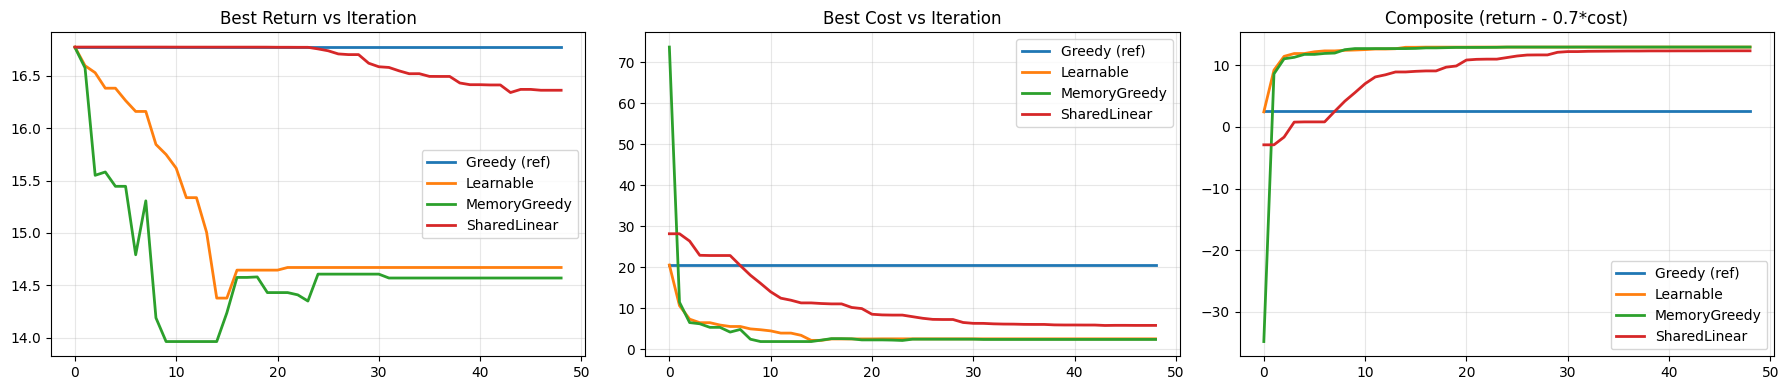

In [18]:
# Quick toggle: use lighter settings for faster demo runs
FAST_DEMO = True
if FAST_DEMO:
    TUNE_CFG = TuneConfig(
        iterations=48,             # more iterations for gradual gains
        candidates_per_iter=3,     # fewer candidates per iter to reduce big jumps
        episodes=3,
        horizon=288,
        noise_scale=0.075,         # smaller perturbations
        seed=2025,
    )
else:
    TUNE_CFG = TuneConfig(
        iterations=120,             # deeper search
        candidates_per_iter=4,      # moderate candidates per iter
        episodes=5,                 # reduce variance
        horizon=288,
        noise_scale=0.075,          # balanced exploration
        seed=2025,
    )

# Composite weighting used throughout Section 5
ALPHA = 0.7

# Consistent initial evaluation (Greedy and initial priors), same settings as tuning
show("section: Initial Evaluation (Consistent Settings)")
initial5 = {}

# Greedy (0)
mean_ret_g, std_ret_g, mean_cost_g, m_g = evaluate_policy(
    policy_fn=baseline_policy_fn, make_env_fn=make_env_dict,
    episodes=TUNE_CFG.episodes, horizon=TUNE_CFG.horizon,
    track_metrics=['satisfaction', 'components', 'actions'], verbose=False)
initial5['Greedy (0)'] = {
    'mean_return': mean_ret_g, 'std_return': std_ret_g, 'mean_cost': mean_cost_g,
    'satisfaction': m_g.get('true_satisfaction_mean', m_g.get('satisfaction_mean', 0.0)),
    'composite': float(mean_ret_g - ALPHA * mean_cost_g),
}

# Learnable (initial)
mean_ret_li, std_ret_li, mean_cost_li, m_li = evaluate_policy(
    policy_fn=learnable.get_action, make_env_fn=make_env_dict,
    episodes=TUNE_CFG.episodes, horizon=TUNE_CFG.horizon,
    track_metrics=['satisfaction', 'components', 'actions'], verbose=False)
initial5['Learnable Greedy (init)'] = {
    'mean_return': mean_ret_li, 'std_return': std_ret_li, 'mean_cost': mean_cost_li,
    'satisfaction': m_li.get('true_satisfaction_mean', m_li.get('satisfaction_mean', 0.0)),
    'composite': float(mean_ret_li - ALPHA * mean_cost_li),
}

# Shared Linear (initial)
mean_ret_si, std_ret_si, mean_cost_si, m_si = evaluate_policy(
    policy_fn=shared.get_action, make_env_fn=make_env_dict,
    episodes=TUNE_CFG.episodes, horizon=TUNE_CFG.horizon,
    track_metrics=['satisfaction', 'components', 'actions'], verbose=False)
initial5['Shared Linear (init)'] = {
    'mean_return': mean_ret_si, 'std_return': std_ret_si, 'mean_cost': mean_cost_si,
    'satisfaction': m_si.get('true_satisfaction_mean', m_si.get('satisfaction_mean', 0.0)),
    'composite': float(mean_ret_si - ALPHA * mean_cost_si),
}

# Memory Greedy (initial)
memory.reset_memory()
mean_ret_mi, std_ret_mi, mean_cost_mi, m_mi = evaluate_policy(
    policy_fn=memory.get_action, make_env_fn=make_env_dict,
    episodes=TUNE_CFG.episodes, horizon=TUNE_CFG.horizon,
    track_metrics=['satisfaction', 'components', 'actions'], verbose=False)
initial5['Memory Greedy (init)'] = {
    'mean_return': mean_ret_mi, 'std_return': std_ret_mi, 'mean_cost': mean_cost_mi,
    'satisfaction': m_mi.get('true_satisfaction_mean', m_mi.get('satisfaction_mean', 0.0)),
    'composite': float(mean_ret_mi - ALPHA * mean_cost_mi),
}

initial5_df = pd.DataFrame(initial5).T.round(3)
show("table", df=initial5_df, title="Initial Results (return, cost, composite)")

# Clarify composite definition
show("text: Composite score = mean_return - ALPHA * mean_cost, with ALPHA = {alpha}", alpha=ALPHA)

show("header: Tuning Learnable Greedy (4 params)")
learnable, learn_hist = tune_policy(learnable, make_env_dict, TUNE_CFG, alpha=ALPHA)
show("result: Learnable Greedy tuned")
show_metrics(learnable.describe(), title="Learned Thresholds")
try:
    show("table", df=learn_hist.loc[learn_hist['is_milestone'], ['iter','best_return','best_cost','best_composite']].round(3), title="Milestones — Learnable Greedy")
except Exception:
    pass

show("header: Tuning Shared Linear (4 params)")
shared, shared_hist = tune_policy(shared, make_env_dict, TUNE_CFG, alpha=ALPHA)
show("result: Shared Linear tuned")
show_metrics(shared.describe(), title="Shared Parameters")
try:
    show("table", df=shared_hist.loc[shared_hist['is_milestone'], ['iter','best_return','best_cost','best_composite']].round(3), title="Milestones — Shared Linear")
except Exception:
    pass

show("header: Tuning Memory-Augmented Greedy (5 params)")
memory.reset_memory()
memory, mem_hist = tune_policy(memory, make_env_dict, TUNE_CFG, alpha=ALPHA)
show("result: Memory-Augmented tuned")
show_metrics(memory.describe(), title="Memory Policy Parameters")
try:
    show("table", df=mem_hist.loc[mem_hist['is_milestone'], ['iter','best_return','best_cost','best_composite']].round(3), title="Milestones — Memory Greedy")
except Exception:
    pass

# Plot tuning traces
# Seed traces with iter=0 initial points, then concatenate tuning histories
learn_init_row = pd.DataFrame([{'iter': 0, 'best_return': mean_ret_li, 'best_cost': mean_cost_li, 'best_composite': float(mean_ret_li - ALPHA * mean_cost_li), 'policy': 'Learnable'}])
shared_init_row = pd.DataFrame([{'iter': 0, 'best_return': mean_ret_si, 'best_cost': mean_cost_si, 'best_composite': float(mean_ret_si - ALPHA * mean_cost_si), 'policy': 'SharedLinear'}])
mem_init_row = pd.DataFrame([{'iter': 0, 'best_return': mean_ret_mi, 'best_cost': mean_cost_mi, 'best_composite': float(mean_ret_mi - ALPHA * mean_cost_mi), 'policy': 'MemoryGreedy'}])

trace_df = pd.concat([
    learn_init_row,
    learn_hist.assign(policy='Learnable'),
    shared_init_row,
    shared_hist.assign(policy='SharedLinear'),
    mem_init_row,
    mem_hist.assign(policy='MemoryGreedy'),
], ignore_index=True)

# Add Greedy (0) reference line across iterations (horizontal reference)
try:
    max_iter = int(trace_df['iter'].max())
    greedy_ref = pd.DataFrame({
        'iter': np.arange(0, max_iter + 1),
        'best_return': mean_ret_g,
        'best_cost': mean_cost_g,
        'best_composite': float(mean_ret_g - ALPHA * mean_cost_g),
        'policy': 'Greedy (ref)'
    })
    trace_df_plot = pd.concat([trace_df, greedy_ref], ignore_index=True)
except Exception:
    trace_df_plot = trace_df

quick_plot({
    'layout': '1x3', 'size': (18, 4), 'plots': [
        {'type': 'line', 'data': trace_df_plot, 'x': 'iter', 'y': 'best_return', 'group': 'policy', 'legend': True, 'title': 'Best Return vs Iteration'},
        {'type': 'line', 'data': trace_df_plot, 'x': 'iter', 'y': 'best_cost', 'group': 'policy', 'legend': True, 'title': 'Best Cost vs Iteration'},
        {'type': 'line', 'data': trace_df_plot, 'x': 'iter', 'y': 'best_composite', 'group': 'policy', 'legend': True, 'title': 'Composite (return - 0.7*cost)'},
    ]
})

## 5. Final Comparison: Simple vs Complex

In [19]:
all_policies: Dict[str, Callable[[Any], np.ndarray]] = {
    'Greedy (0)': baseline_policy_fn,
    'Learnable Greedy (4)': learnable.get_action,
    'Shared Linear (4)': shared.get_action,
    'Memory Greedy (5)': memory.get_action,
}

final_results = {}
for name, policy_fn in all_policies.items():
    if hasattr(policy_fn, '__self__') and hasattr(policy_fn.__self__, 'reset_memory'):
        policy_fn.__self__.reset_memory()
    env_fn = make_env_dict
    mean_ret, std_ret, mean_cost, metrics = evaluate_policy(
        policy_fn=policy_fn, make_env_fn=env_fn,
        episodes=5, horizon=288,
        track_metrics=['satisfaction', 'components', 'actions'], verbose=False)
    final_results[name] = {
        'mean_return': mean_ret,
        'std_return': std_ret,
        'mean_cost': mean_cost,
        'satisfaction': metrics.get('true_satisfaction_mean', metrics.get('satisfaction_mean', 0.0)),
    }

final_df = pd.DataFrame(final_results).T.round(3)
show("section: Final Performance Rankings (Composite First)")
# Add composite metric and present it as the first column; rank by highest composite
try:
    final_df['composite'] = final_df['mean_return'] - ALPHA * final_df['mean_cost']
    # Reorder columns with composite first if available
    ordered_cols = ['composite', 'mean_return', 'std_return', 'mean_cost', 'satisfaction']
    final_df = final_df[[c for c in ordered_cols if c in final_df.columns]].round(3)
    show("table", df=final_df.sort_values('composite', ascending=False))
except Exception:
    # Fallback to original sorting if composite could not be computed
    show("table", df=final_df.sort_values('mean_return', ascending=False))

# Parameter counts (computed, not hard-coded)
param_counts = {
    'Greedy (0)': 0,
    'Learnable Greedy (4)': learnable.parameter_count(),
    'Shared Linear (4)': shared.parameter_count(),
    'Memory Greedy (5)': memory.parameter_count(),
}

scatter_df = pd.DataFrame({
    'policy': list(final_df.index),
    'params': [param_counts.get(k, 0) for k in final_df.index],
    'return': final_df['mean_return'].values,
})

,composite,mean_return,std_return,mean_cost,satisfaction
Shared Linear (4),12.760,15.275,7.697,3.593,0.864
Learnable Greedy (4),12.562,13.604,7.021,1.488,0.766
Memory Greedy (5),12.533,13.513,6.969,1.400,0.761
Greedy (0),6.652,15.636,7.909,12.834,0.884


## 6. Lessons and Recommendations

1. Start with domain knowledge (greedy structure); it is surprisingly strong.
2. Make only critical parts learnable (4–6 parameters suffice for big gains).
3. Share parameters across similar subproblems (one tiny model for all stations).
4. Use minimal memory for temporal patterns (EMA of MOER is effective).
5. Prioritize robustness; simple policies degrade gracefully compared to large NNs.

The EV case study reinforces: every added parameter should earn its place with measurable improvement.